I am using [Canadian Longterm Outdoor UAV Dataset](https://www.dynsyslab.org/cloud-dataset/#utiasfield) or CLOUD datasets. After sifting through the list of available list of datasets in CLOUD, I have decided to use the `Winter Trial 1` dataset. The winter trial dataset looks like the dataset with the longest flight time. Before I fuse the sensors, I will need to make some important transformations. 

### Hardware

Our datasets were captured using a DJI M600 Pro. A StereoLabs camera was attached using a DJI Ronin-Mx Gimbal to the M600 platform. We collect grey-scale camera images (from the left camera) at 15 Hz. We additionally store logged GPS data, raw IMU data and the gimbal orientation.

The transformation (in the form of a vector followed by a quaternion) describing the rigid transform between the vehicle frame and the base frame is given by: `[0.0, 0.0, 0.495, 0.0, 0.0, 0.0, 1.0]`

The transformation (in the form of a vector followed by a quaternion) describing the rigid transform between the gimbal frame and the camera frame is given by: `[0.05, -0.05, -0.02, -0.5, 0.5, -0.5, 0.5]`

The transformation (in the form of a vector followed by a quaternion) describing the transform between the gimbal frame (in neutral position – i.e. with the same orientation as the vehicle) and the vehicle frame is given by: `[0.073, 0.11, -0.261, 0.0, 0.0, 0.0, 1.0]`

### Description of Data Products
Coordinate frames in the figure ![](m600_frames4.png) illustrates the coordinate frames applicable to this dataset. All data is described in one of these frames. 
- The vehicle frame is approximately located at the center of mass of the M600.
- The 4×4 homogeneous transformation matrices describing the rigid transformations between the sensor and vehicle frames are provided above.
- Ground Frame: There are two Ground frames, i.e., East-North-Up (ENU) and North-East-Down (NED).
- Vehicle and Base Frames: The Vehicle and Base frames are both Forward-Left-Up (FLU). The Vehicle frame is aligned at approximately the center-of-gravity of the M600 while the Base frame is shift down vertically as given by `[0.0, 0.0, 0.495, 0.0, 0.0, 0.0, 1.0]`.

### Data streams

![](table.png)

 - The roll and pitch angles are given relative to the global NED frame, however the yaw angle is given relative to the Vehicle/Base frames. Unfortunately, this is the convention used in the [DJI ROS SDK](https://wiki.ros.org/dji_sdk). To estimate the rotation (as a quaternion) from the Gimbal to the Vehicle/Base frames, find the transformation matrix above.
 
 - All timestamps are Unix timestamps given in nanoseconds.
 
- Vector Files: The acceleration, velocity and gimbal state data is stored as vector data. The vector data is contained in human-readable, comma-delimited text files. Each row provides the timestamp followed by the 3-D vector (x, y, z) in the associated frame given in the Description section.

- Quaternion Files: The attitude and gimbal state data is stored as quaternion data. The quaternion data is contained in human-readable, comma-delimited text files. Each row provides the timestamp followed by the 4-D quaternion (x, y, z, w) which represents the rotation from frame A to frame B as listed in the Description section.


- GPS Files: The GPS measurement files are human-readable and comma-delimited with each row providing the timestamp, latitude, longitude and altitude (in **meters** with respect to WGS 84 ellipsoid).

- Euler Angles Files: euler angles are in the standard ZYX convention (roll, pitch, yaw). They are given in **degrees**.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
gps          = pd.read_csv("utiaswinter_trial1/teach/gps.csv")
gimbal_state = pd.read_csv("utiaswinter_trial1/teach/gimbal_state.csv")
imu          = pd.read_csv("utiaswinter_trial1/teach/imu.csv")
velocity     = pd.read_csv("utiaswinter_trial1/teach/velocities.csv")
gimbal_angle = pd.read_csv("utiaswinter_trial1/teach/gimbal_angles.csv")
attitude     = pd.read_csv("utiaswinter_trial1/teach/attitude.csv")

In [47]:
# convert unix timestamps into flight time format in seconds (start time 0 seconds)
gps['Time_sec']          = gps['Timestamp']/1e9 - (gps['Timestamp']/1e9).iloc[0]
gimbal_state['Time_sec'] = gimbal_state['Timestamp']/1e9 - (gimbal_state['Timestamp']/1e9).iloc[0]

In [50]:
gimbal_state[' pos x']

0       -0.006881
1        0.019345
2        0.019314
3        0.019314
4        0.019534
           ...   
15029    0.069858
15030    0.069476
15031    0.069514
15032    0.069514
15033    0.069873
Name:  pos x, Length: 15034, dtype: float64

In [38]:
gps_lat = gps[' latitude'].to_numpy() 
gps_lon = gps[' longitude'].to_numpy()
gps_alt = gps[' altitude'].to_numpy()  


R = 6371000 # Earth's radius in meters
init_lat = gps_lat[0]
init_lon = gps_lon[0]
init_alt = gps_alt[0]

### simplified ECEF to ENU conversion

gps_x_coord = (gps_lon - init_lon) * np.cos(np.deg2rad(init_lat)) * (np.pi/180) * R
gps_y_coord = (gps_lat - init_lat) * (np.pi/180) * R
gps_z_coord = (gps_alt - init_alt)


gps_pos_data = np.stack((gps_x_coord, gps_y_coord, gps_z_coord), axis=1)

In [52]:
# helper function for plotting flight path

def plot_2d_path(x_coords, y_coords, title):
    plt.figure(figsize=(8,6))
    plt.plot(
        x_coords, y_coords,
        marker='o',       # circle marker
        markersize=1,     # make marker smaller
        linestyle='-',    # solid line
        linewidth=1,      # make line thinner
        color='b',
        label='Flight Path'
    )
    plt.scatter(x_coords[0], y_coords[0], s=200, color='red', marker='*', label='Start')
    plt.xlabel("X (meters, East)")
    plt.ylabel("Y (meters, North)")

    plt.title(f"{title}")
    plt.legend()
    plt.axis('equal')  # equal aspect ratio so trajectory isn’t distorted
    plt.grid(True)
    plt.show()
    
# helper function to transform quaternion to a rotation matrix
def quat_to_rot(q):
    """
    input: normalized np.array
    q = w + xi+ yj+ zk or q = [w,x,y,z]
    Quaternion [w,x,y,z] to rotation matrix: 
    https://automaticaddison.com/how-to-convert-a-quaternion-to-a-rotation-matrix/
    Example: 
    a_body: body frame acceleration  
    a_earth: earth frame acceleration
    a_earth = R a_body
    https://automaticaddison.com/how-to-describe-the-rotation-of-a-robot-in-3d/
    """
    w, x, y, z = q
    R = np.array([
        [1-2*(y**2+z**2), 2*(x*y-z*w),     2*(x*z+y*w)],
        [2*(x*y+z*w),     1-2*(x**2+z**2), 2*(y*z-x*w)],
        [2*(x*z-y*w),     2*(y*z+x*w),     1-2*(x**2+y**2)]
    ])
    return R


def normalize_quat(q):
    """
    q is an np.array
    q^2 = w^2 + x^2 + y^2 + z^2
    """
    return q / np.linalg.norm(q)

def quat_derivative(q, omega):
    """
    omega:              (3x1) angular velocity vector
    q:                  (4x1) quaternion vector
    q derivative:       q_dot = 0.5 * omega_operator * q
    omega_operator:     https://ahrs.readthedocs.io/en/latest/filters/angular.html#id12                   
    """
    w_x, w_y, w_z = omega
    w, x, y, z = q
    q_dot = 0.5 * np.array([
        -x*w_x - y*w_y - z*w_z,
         w*w_x + y*w_z - z*w_y,
         w*w_y - x*w_z + z*w_x,
         w*w_z + x*w_y - y*w_x
    ])
    return q_dot

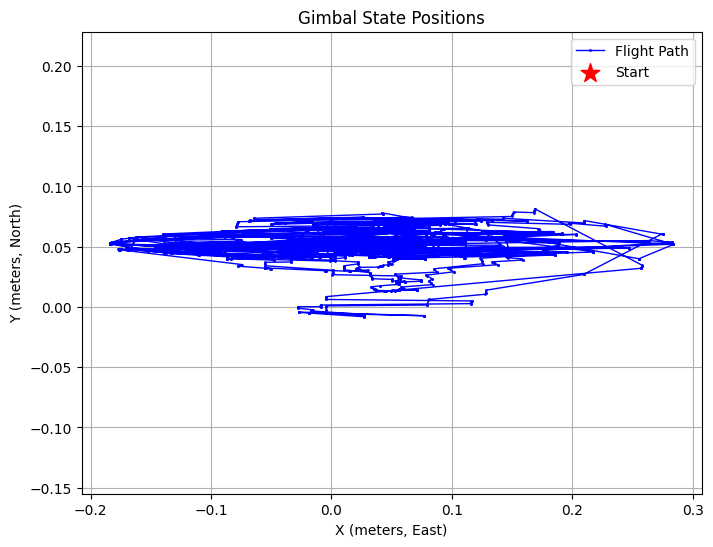

In [56]:
plot_2d_path(gimbal_state[' pos x'][0:5000], gimbal_state[' pos y'][0:5000], 'Gimbal State Positions')

In [60]:
gps[0:6000]

,Timestamp,latitude,longitude,altitude,Time_sec
0,1.604610e+18,43.781741,-79.466295,157.827347,0.000000
1,1.604610e+18,43.781741,-79.466295,157.827881,0.042109
2,1.604610e+18,43.781741,-79.466295,157.828613,0.079250
3,1.604610e+18,43.781741,-79.466295,157.829041,0.100368
4,1.604610e+18,43.781741,-79.466295,157.829361,0.121965
...,...,...,...,...,...
5995,1.604610e+18,43.782118,-79.465646,157.728470,123.307040
5996,1.604610e+18,43.782118,-79.465645,157.727615,123.321001
5997,1.604610e+18,43.782118,-79.465646,157.727249,123.340300
5998,1.604610e+18,43.782118,-79.465645,157.726944,123.360521


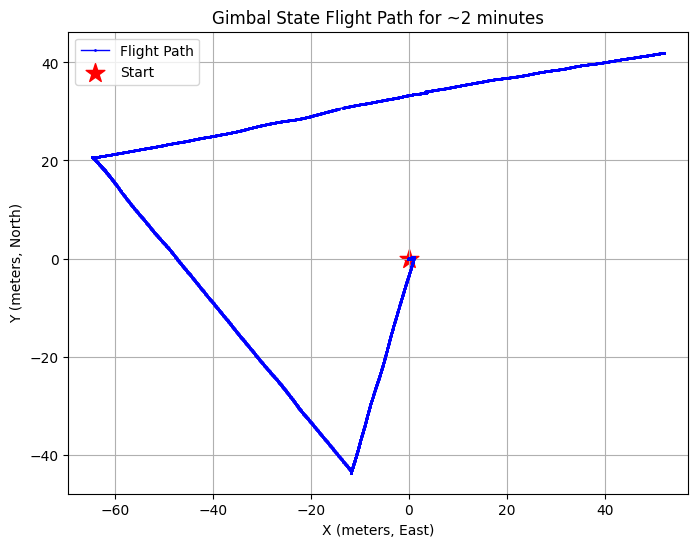

In [61]:
plot_2d_path(gps_x_coord[0:6000], gps_y_coord[0:6000], 'Gimbal State Flight Path for ~2 minutes')

It is clear that neither `gimbal_state` nor `gimbal_angles` are the drone's position coordinates, but the gimbal's. 

### Objective

The goal is to see the effect on pose following the introduction of corrupted GPS data. Advanced spoofing techniques like spoof and drift is meant to give the autopilot false impressions of drift. The autopilot then makes corrections to remain on course. This results in false correction and instills false beliefs: autopilot thinks it's on course, in reality the drone drifts off course. We have the following steps ahead of us: 

- Create a dataset from Kalman filter (w/o airdrag) fusing (true) GPS, Accelerometer, Gyro, Barometer (IMU) and Magnetometer together: call it `planned_course`. 
- Corrupt GPS Data to simulate spoofing in a dataset, call it `spoofed_gps`.
- Fuse `spoofed_gps`, Accelerometer, Gyro, Barometer, and Magnetometer together using the same Kalman filter, call it: `spoofed_course'.
- Compare the (x,y) coordinates of `planned_course` and `spoofed_course`.



### Pros

- The dataset comes with 'estimated' velocity data. This is great news because it saves us the trouble of having to process IMU + Magnetometer measurements to extract velocity and distance. Now I must check if GPS was incorporated into the estimation or not. Ideally, It'd be nice if it isn't but feels unlikely.
- Because `attitude` comes processed, it is still possible to run a fusion algorithm. We'll still use accelerometer data, but won't have any need for gyroscope or magnetometer data. 